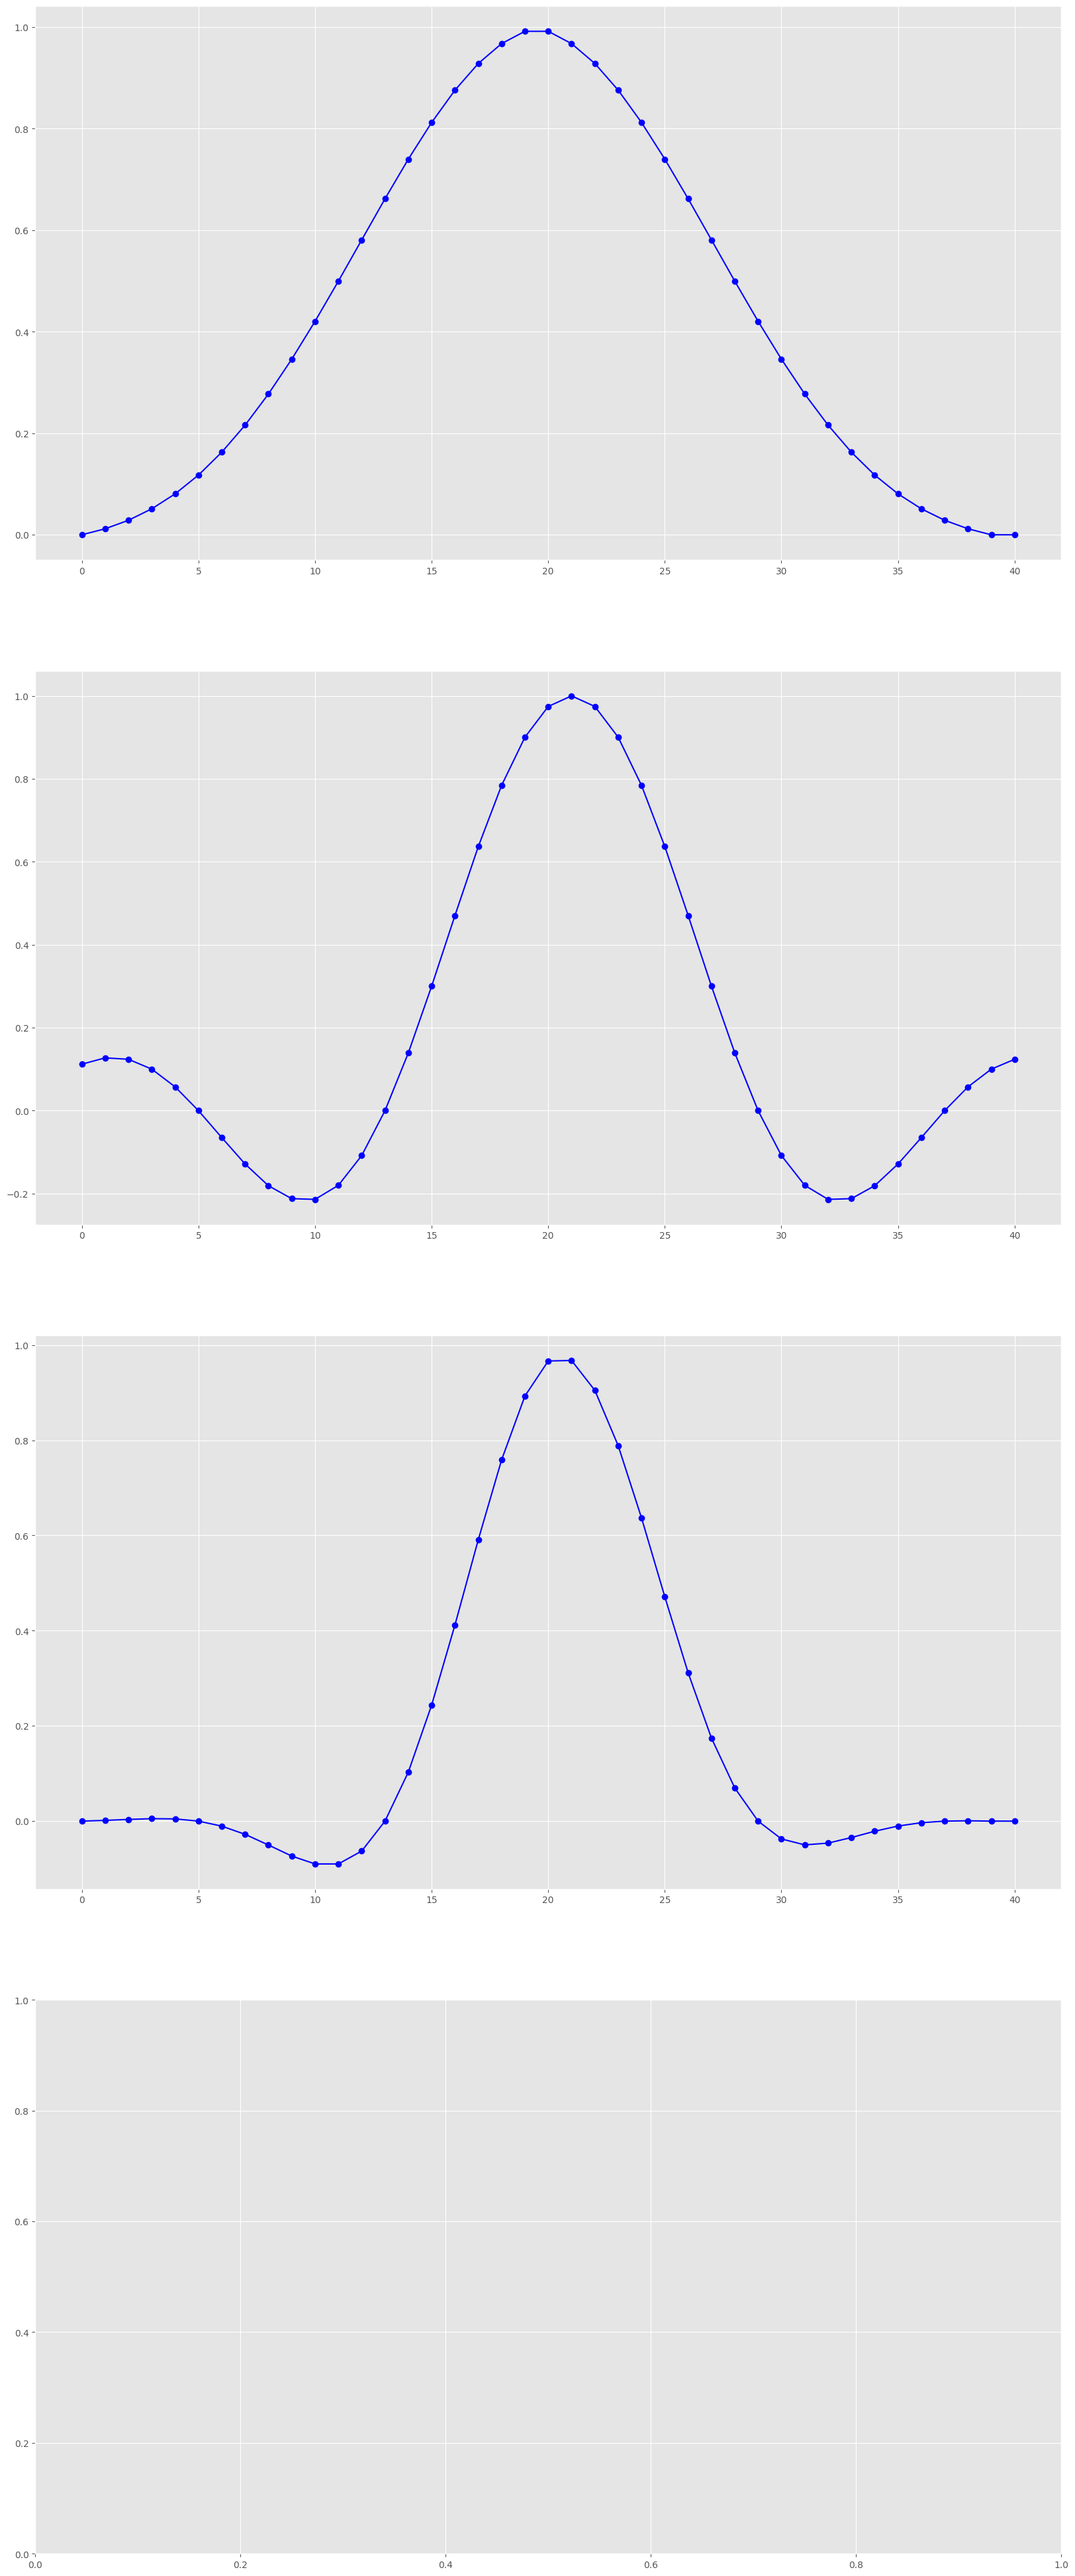

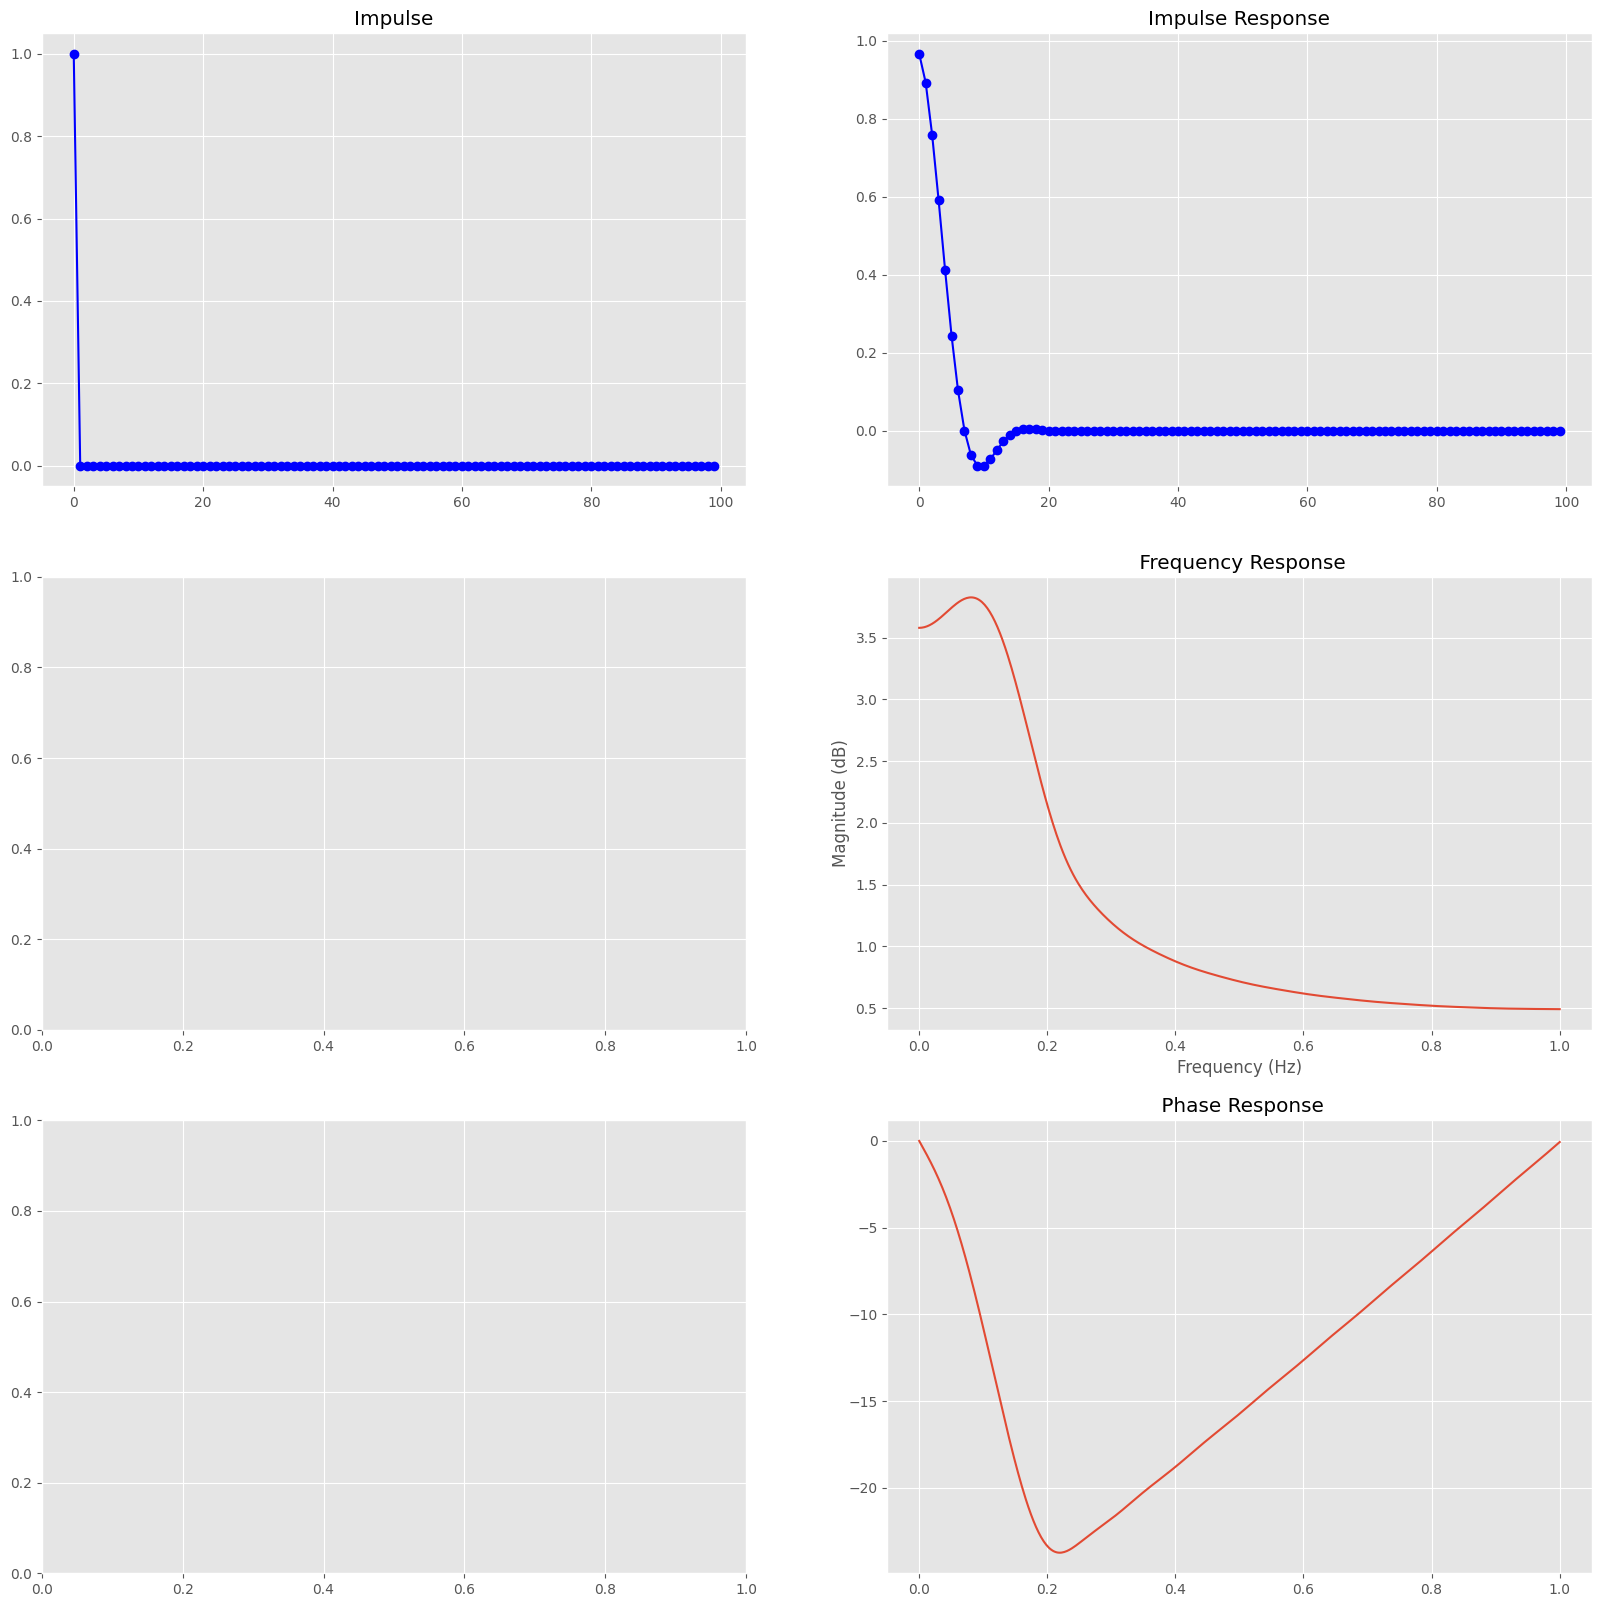

In [18]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from matplotlib import style 

plt.style.use('ggplot')



def plot(impulse, response):
    x=np.linspace(0, 1, response.size//2)
    
    
    #with np.errstate(divide='ignore', invalid='ignore'):
    if True:
        response_fft = fft.fft(response)
        #y=(20 * np.log10(np.abs(response_fft)))[:response_fft.size//2]
        y=((np.abs(response_fft)))[:response_fft.size//2]
        phase=(20 * np.angle(response_fft))[:response_fft.size//2]
        

    fig, ax = plt.subplots(3,2, figsize=(20, 20))

    ax[0][0].plot(impulse[:100],'bo-')
    ax[0][0].set_title('Impulse')
    ax[0][1].plot(response[:100],'bo-')
    ax[0][1].set_title('Impulse Response')

    ax[1][1].plot(x, y, label='b')
    ax[1][1].set_xlabel('Frequency (Hz)')
    ax[1][1].set_ylabel('Magnitude (dB)')
    ax[1][1].set_title(' Frequency Response')

    ax[2][1].plot(x, phase, label='b')
    ax[2][1].set_title(' Phase Response')

samples=1000

impulse = np.zeros(samples)
impulse[0] = 1

def feedForward(x, a0, a1):
    b = np.zeros(samples)
    for i in range(0, x.size):
        b[i] = a0 * x[i] + a1 * x[i-1]
    return b

response = feedForward(impulse,0.5, 0.5);
#

impulse = np.zeros(samples)
impulse[0] = 1

A = 90
K = 32

Nn = 3
Nz = 20
Nzd = Nz * 2 + 1
L = 1 << Nn


def beta():
    if A > 50:
        return 0.1102 * (A - 8.7)
    elif A > 21:
        return 0.5842 * (A - 21)**(2./5.) + 0.07886 * (A - 21)
    else:
        return 0.0

# From https://dsp.stackexchange.com/questions/37714/kaiser-window-approximation
def bessel_coeff():
    result = np.zeros(K)
    fact = 1

    for k in range(K):
        fact *= (k + 1)
        exp = 2 ** k
        result[k] = 1 / (fact * exp)**2

    return result

def bessel(x, bc):
    k = K - 1
    x2 = x**2
    y = x2 * bc[k]
    for k in range(K - 2, 0, -1):
        y = x2 * (bc[k] + y)

    return y

def kaiserwindow(bc):
    b = beta()

    b_beta = bessel(b, bc)

    m2 =  Nzd//2
    y = np.zeros(Nzd)

    for n in range(m2 + 1):
        bn = b * ( 1 - ( n / m2 )**2 )**0.5
        bb = bessel(bn, bc)
        y[n + m2 - 1] = (1 / b_beta) * bb
        y[m2 - n] = y[n + m2 - 1]

    return y

#M = Nzd * L
bc = bessel_coeff()

x = np.array(np.arange(-16, 16, 1/Nzd))
w = kaiserwindow(bc)

fc = 1 / L
#fc=1
sinco = [np.sin(np.pi * fc * i) / (np.pi * fc * i) if i != 0 else 1 for i in range(-Nzd//2, Nzd//2)]
sinc =  [w[i]*sinco[i] for i in range(Nzd)]


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,figsize=(20, 50))

ax1.plot(w, 'bo-')
ax2.plot(sinco, 'bo-')
ax3.plot(sinc, 'bo-')

#plt.plot(sinc, 'bo-')

def sinc_filter(x):
    b = np.zeros(samples)

    for i in range(0, x.size):
        for j in range(0, Nzd):
            x_pos = i + j - (Nzd//2)
            if (x_pos < 0 or x_pos >= x.size):
                True
            else:
                b[i] += x[x_pos]*sinc[j]
    return b

def tent(x,a0,a1,a2):
    b = np.zeros(samples)
    for i in range(0, x.size-1):
        b[i] = a0* x[i-1] + a1 * x[i] + a2*x[i+1]
    return b

#response = tent(impulse, 0.10, 0.5, 0.10)

response = sinc_filter(impulse)
plot(impulse, response)


